In [2]:
import pylab
import imageio
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [3]:
train_vid = '/home/asya/Documents/CodePractice/SpeedChallenge/speed_challenge_2017/data/train.mp4'

AxesImage(54,36;334.8x217.44)


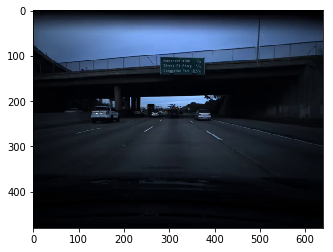

In [76]:
vid = imageio.get_reader(train_vid,  'ffmpeg')
nums = [0,1,2,3,4,5]
vid_frames = []
for num in nums:
    image = vid.get_data(num)
    vid_frames.append(image)

print(pylab.imshow(vid_frames[0]))

In [99]:
np.random.seed(2)
np.random.rand(5)

array([0.4359949 , 0.02592623, 0.54966248, 0.43532239, 0.4203678 ])

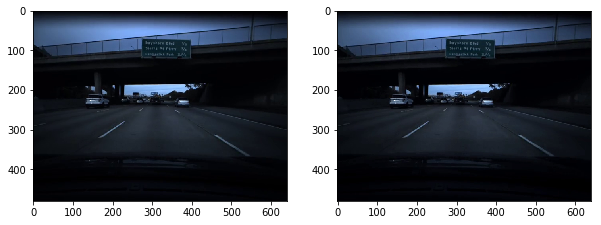

In [192]:
def brightness_augment(image, offset, rand_amplitude):
    """
    Augments the brightness of the image by multiplying the saturation by a uniform random variable
    Input: image (RGB)
    returns: image with brightness augmentation
    """
    hsv_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    factor = offset + rand_amplitude*np.random.uniform()
    hsv_image[:,:,2] = hsv_image[:,:,2] * factor
    im = cv2.cvtColor(hsv_image, cv2.COLOR_HSV2RGB)
    im = np.round(255.*im/np.max(im))
    return im.astype('uint8')

def preproc_image(image):
    if image.ndim == 3:
        # perform brightness augmentation only on the second channel
        im = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        im = image.copy
  
    # apply gamma
    im = (im/255.)**1
    im = np.round(255.*im/np.max(im))
    
   # hsv_image = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)
   # bright_factor = 0.1 + np.random.uniform()
   # hsv_image[:,:,2] = hsv_image[:,:,2] * bright_factor
    
  #  im = cv2.cvtColor(hsv_image, cv2.COLOR_BGR2GRAY)
 #   image_rgb[:,:,:] = image_rgb[:,:,:] ** 2
 #   image_rgb[:,:,0] = image_rgb[:,:,1] ** 0.5
#    image_rgb[:,:,0] = image_rgb[:,:,1] ** 0.5

    return im.astype('uint8')
plt.figure(figsize = (10,5))
plt.subplot(121)
pylab.imshow(vid_frames[5])
plt.subplot(122)
pylab.imshow(brightness_augment(vid_frames[5],0.5,0.5))

In [188]:
np.min(brightness_augment(vid_frames[5],10,1))

0

In [5]:
## Get the video dimensions
v = vid_frames[0].shape[0]
h = vid_frames[0].shape[1]
print(v)

480


In [193]:
## Lucas kanade algorithm for finding the optic flow

x = np.arange(0, h, 10)
y = np.arange(0, v, 10)
xx, yy = np.meshgrid(x, y, sparse=False)
p0 = np.vstack((xx.ravel(),yy.ravel())).T.astype('float32')

# Lucas kanade params
lk_params = dict(winSize = (15, 15),
                 maxLevel = 4,
                 criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

def filter_large_vals(U,V,thresh):
    idx1 = np.abs(U)>thresh
    idx2 = np.abs(V)>thresh
    U[idx1]=np.nan
    U[idx2]=np.nan
    V[idx1]=np.nan
    V[idx2]=np.nan
    return U,V

'''
## Possible to process in color
fr0 = cv2.cvtColor(vid_frames[0], cv2.COLOR_BGR2GRAY)
fr1 = cv2.cvtColor(vid_frames[1], cv2.COLOR_BGR2GRAY)
fr2 = cv2.cvtColor(vid_frames[1], cv2.COLOR_BGR2GRAY)

'''
## Brightness_augment
fr0 = brightness_augment(vid_frames[5],0.5,0.5)
fr1 = brightness_augment(vid_frames[4],0.5,0.5)
fr2 = brightness_augment(vid_frames[3],0.5,0.5)



vel_points,_,_ = cv2.calcOpticalFlowPyrLK(fr1, fr0, p0, None, **lk_params)

flow_list = np.hstack((p0,vel_points))
flow_array = np.asarray(flow_list)
X = flow_array[:,0]
Y = flow_array[:,1]
U = flow_array[:,2]-flow_array[:,0]
V = flow_array[:,3]-flow_array[:,1]

acc_points,_,_ = cv2.calcOpticalFlowPyrLK(fr2, fr1, p0, None, **lk_params)
acc_list = np.hstack((p0,acc_points))
acc_array = np.asarray(acc_list)
U2 = acc_list[:,2]-acc_list[:,0]
V2 = acc_list[:,3]-acc_list[:,1]
Uacc = U2-U
Vacc = V2-V

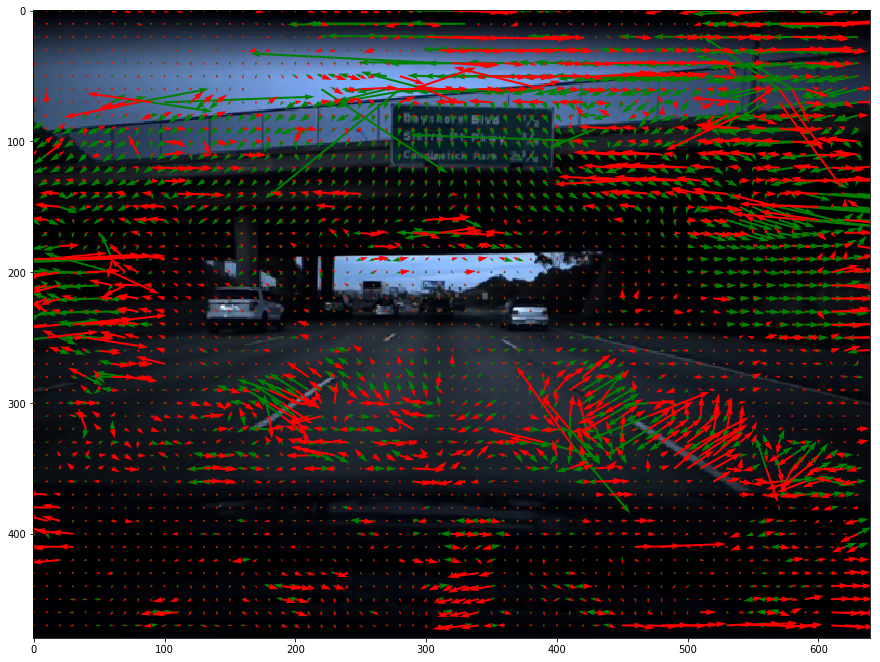

In [194]:
U,V =  filter_large_vals(U,V,200)
U2,V2 =  filter_large_vals(U2,V2,200)
Uacc, Vacc = filter_large_vals(Uacc,Vacc,100)
plt.figure(figsize = (15,15))
pylab.imshow(fr0,cmap = 'gray')
plt.quiver(X, Y, U, V,color = 'g')
plt.quiver(X, Y, Uacc, Vacc,color = 'r')

In [105]:
np.max(U)

0.0

In [126]:
fr1[0,0].type

AttributeError: 'numpy.uint8' object has no attribute 'type'

In [200]:
def opticalFlowDense(image_current, image_next):
    """
    input: image_current, image_next (RGB images)
    calculates optical flow magnitude and angle and places it into HSV image
    * Set the saturation to the saturation value of image_next
    * Set the hue to the angles returned from computing the flow params
    * set the value to the magnitude returned from computing the flow params
    * Convert from HSV to RGB and return RGB image with same size as original image
    """    
    gray_current = cv2.cvtColor(image_current, cv2.COLOR_RGB2GRAY)
    gray_next = cv2.cvtColor(image_next, cv2.COLOR_RGB2GRAY)
    
    hsv = image_next*0
    # set saturation
    hsv[:,:,1] = cv2.cvtColor(image_next, cv2.COLOR_RGB2HSV)[:,:,1]
 
    # Flow Parameters
    #flow_mat = cv2.CV_32FC2
    flow_mat = None
    image_scale = 0.5
    nb_images = 1
    win_size = 15
    nb_iterations = 2
    deg_expansion = 5
    STD = 1.3
    extra = 0

    # obtain dense optical flow paramters
    flow = cv2.calcOpticalFlowFarneback(gray_current, gray_next,  
                                        flow_mat, 
                                        image_scale, 
                                        nb_images, 
                                        win_size, 
                                        nb_iterations, 
                                        deg_expansion, 
                                        STD, 
                                        0)
                                        
        
    # convert from cartesian to polar
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])  
        
    # hue corresponds to direction
    hsv[:,:,0] = ang * (180/ np.pi / 2)
    
    # value corresponds to magnitude
    hsv[:,:,2] = cv2.normalize(mag,None,0,255,cv2.NORM_MINMAX)
    
    # convert HSV to int32's
    hsv = np.asarray(hsv, dtype= np.float32)
    rgb_flow = cv2.cvtColor(hsv,cv2.COLOR_HSV2RGB)

    return rgb_flow

In [226]:
## Brightness_augment
fr0 = brightness_augment(vid_frames[5],0.5,0.5)
fr1 = brightness_augment(vid_frames[4],0.5,0.5)
fr2 = brightness_augment(vid_frames[3],0.5,0.5)
flow = opticalFlowDense(fr1, fr0)
flow2 = opticalFlowDense(fr1, fr2)
acc = flow2-flow

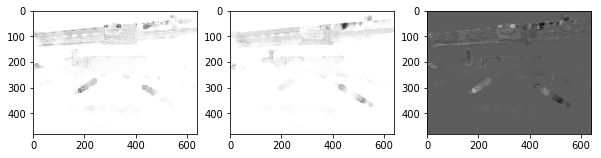

In [230]:
plt.figure(figsize = (10,5))
plt.subplot(131)
plt.imshow(flow[:,:,2],cmap = 'gray')
plt.subplot(132)
plt.imshow(flow2[:,:,2],cmap = 'gray')
plt.subplot(133)
plt.imshow(acc[:,:,2],cmap = 'gray')